# Imports and Settings

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm
from laplace import Laplace
from utils.dataset import get_dataset
from utils.models import get_mlp
from utils.pytorch_learning import fit_map
from utils.metrics import *
import glob
import os
import re

In [2]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,    # 0.01 o 0.001 
        "epochs": 200,    # Echar un vistazo a loss y ver si se estabiliza (a lo mejor converge con 50 épocas)
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1,
        "batch_size": 100
}

In [3]:
torch.manual_seed(params["seed"])
dataset = get_dataset("RedWine", random_state=params["seed"])

In [4]:
# Ruta base de tu carpeta boston
base_path = "redwine"

# Patrón para encontrar todos los archivos *_metrics_fold_*.csv
pattern = os.path.join(base_path, "*_metrics_fold_*.csv")
files = glob.glob(pattern)

# Diccionario para almacenar los DataFrames por método
method_dfs = {}

# Expresión regular para extraer método y número de fold
regex = re.compile(r"([^/\\]+)_metrics_fold_(\d+)\.csv$")

for file in files:
    match = regex.search(file)
    if match:
        method = match.group(1)  # p.ej., "kron" o "lastlayer_lla"
        fold = int(match.group(2))

        # Leer el CSV
        df = pd.read_csv(file)

        # Añadir columna de fold
        df["fold"] = fold

        # Guardar en el diccionario
        if method not in method_dfs:
            method_dfs[method] = []
        method_dfs[method].append(df)

# Convertir cada lista de DataFrames en un único DataFrame por método
for method in method_dfs:
    method_df = pd.concat(method_dfs[method], ignore_index=True)
    # Ordenar por fold para que la tabla esté limpia
    method_df = method_df.sort_values("fold").reset_index(drop=True)
    method_dfs[method] = method_df

# Ahora puedes acceder a cada tabla así:
for method, df in method_dfs.items():
    print(f"\n--- Resultados para {method} ---")
    print(df)


--- Resultados para lastlayer_lla ---
        RMSE       NLL   Q-10   Q-20   Q-30   Q-40   Q-50   Q-60   Q-70  \
0   0.658200  1.013106  0.075  0.225  0.325  0.425  0.500  0.650  0.750   
1   0.557892  0.838329  0.050  0.175  0.250  0.425  0.550  0.700  0.750   
2   0.648544  0.999759  0.050  0.125  0.250  0.350  0.525  0.625  0.700   
3   0.662825  1.031246  0.075  0.175  0.250  0.300  0.375  0.475  0.600   
4   0.786787  1.248184  0.075  0.225  0.350  0.425  0.550  0.650  0.700   
5   0.584506  0.883362  0.150  0.225  0.300  0.400  0.475  0.550  0.725   
6   0.574410  0.864940  0.125  0.150  0.325  0.425  0.525  0.625  0.700   
7   0.579268  0.872718  0.075  0.075  0.225  0.425  0.475  0.575  0.625   
8   0.714251  1.149236  0.050  0.150  0.225  0.325  0.400  0.500  0.575   
9   0.720125  1.143230  0.075  0.225  0.275  0.300  0.475  0.575  0.675   
10  0.755618  1.240980  0.050  0.125  0.225  0.325  0.425  0.600  0.650   
11  0.624606  0.953761  0.075  0.175  0.275  0.425  0.600  0.

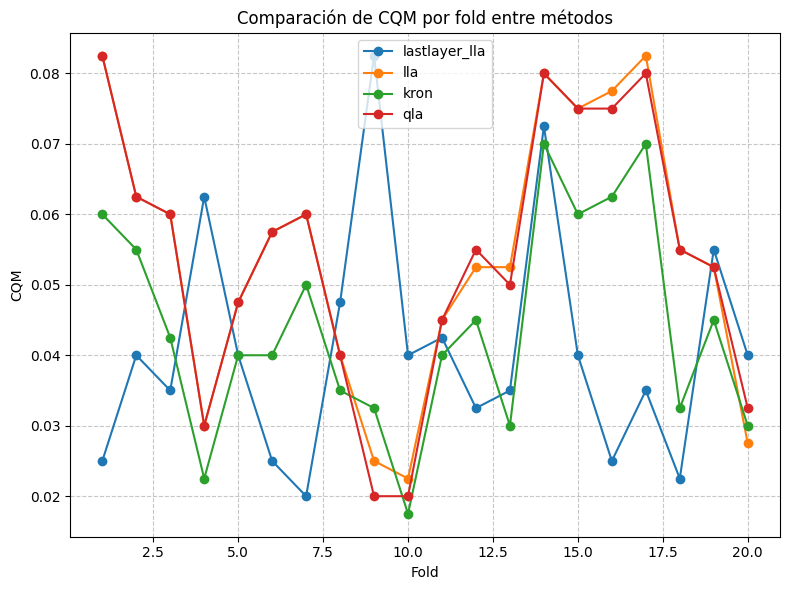

In [5]:
plt.figure(figsize=(8, 6))

for method, df in method_dfs.items():
    if "CQM" in df.columns and "fold" in df.columns:
        plt.plot(df["fold"], df["CQM"], marker="o", label=method)

plt.xlabel("Fold")
plt.ylabel("CQM")
plt.title("Comparación de CQM por fold entre métodos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

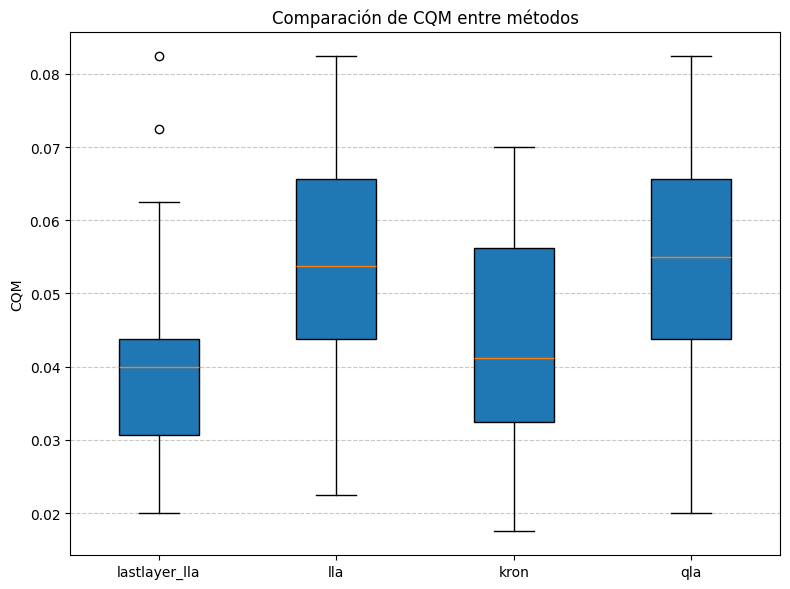

In [6]:
# Extraer datos de CQM para todos los métodos disponibles
data = []
labels = []

for method, df in method_dfs.items():
    if "CQM" in df.columns:  # Asegurarse de que existe la métrica
        data.append(df["CQM"])
        labels.append(method)

plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True)

plt.ylabel("CQM")
plt.title("Comparación de CQM entre métodos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
for method, df in method_dfs.items():
    if "CQM" in df.columns:
        mean_cqm = df["CQM"].mean()
        std_cqm = df["CQM"].std()
        print(f"{method}: CQM media = {mean_cqm:.4f}, Desviación estándar = {std_cqm:.4f}")

lastlayer_lla: CQM media = 0.0409, Desviación estándar = 0.0165
lla: CQM media = 0.0544, Desviación estándar = 0.0190
kron: CQM media = 0.0440, Desviación estándar = 0.0151
qla: CQM media = 0.0540, Desviación estándar = 0.0190


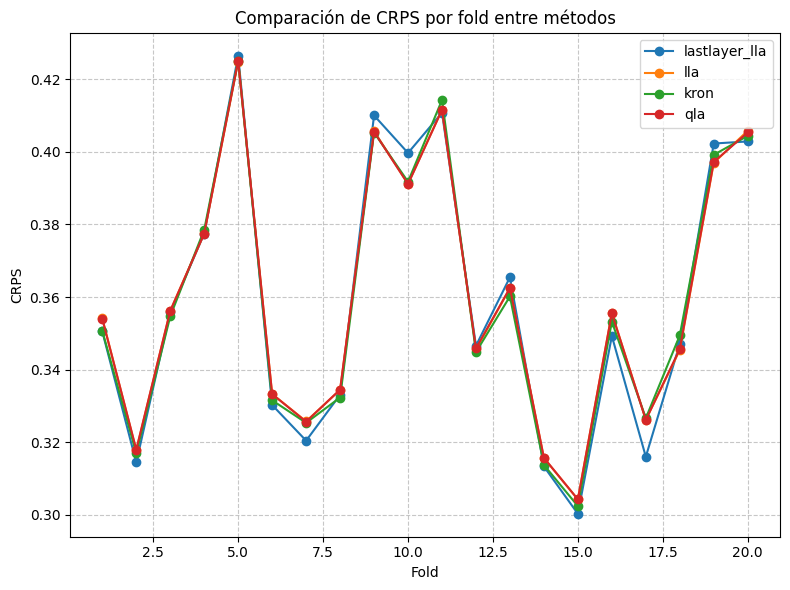

In [8]:
plt.figure(figsize=(8, 6))

for method, df in method_dfs.items():
    if "CRPS" in df.columns and "fold" in df.columns:
        plt.plot(df["fold"], df["CRPS"], marker="o", label=method)

plt.xlabel("Fold")
plt.ylabel("CRPS")
plt.title("Comparación de CRPS por fold entre métodos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

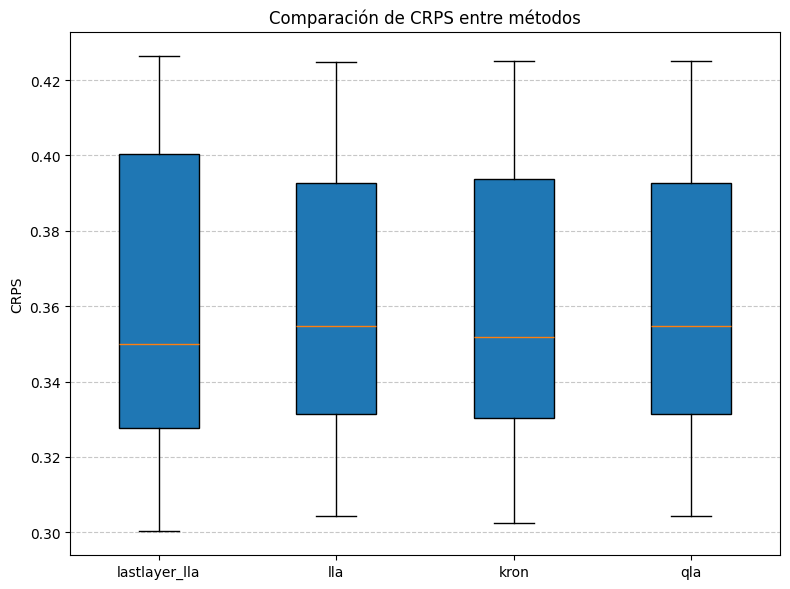

In [9]:
data = []
labels = []

for method, df in method_dfs.items():
    if "CRPS" in df.columns:  # Asegurarse de que existe la métrica
        data.append(df["CRPS"])
        labels.append(method)

plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True)

plt.ylabel("CRPS")
plt.title("Comparación de CRPS entre métodos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
for method, df in method_dfs.items():
    if "CRPS" in df.columns:
        mean_crps = df["CRPS"].mean()
        std_crps = df["CRPS"].std()
        print(f"{method}: CRPS media = {mean_crps:.4f}, Desviación estándar = {std_crps:.4f}")

lastlayer_lla: CRPS media = 0.3586, Desviación estándar = 0.0387
lla: CRPS media = 0.3595, Desviación estándar = 0.0361
kron: CRPS media = 0.3590, Desviación estándar = 0.0368
qla: CRPS media = 0.3595, Desviación estándar = 0.0360


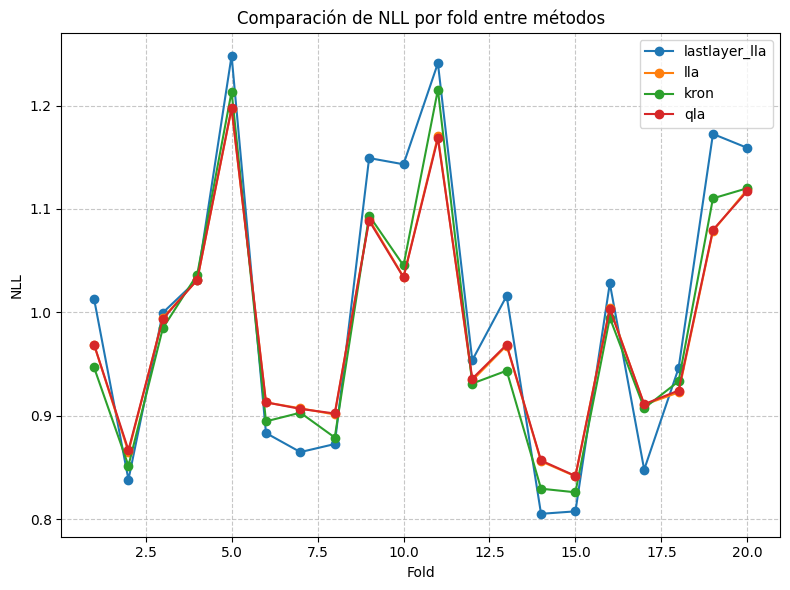

In [11]:
plt.figure(figsize=(8, 6))

for method, df in method_dfs.items():
    if "NLL" in df.columns and "fold" in df.columns:
        plt.plot(df["fold"], df["NLL"], marker="o", label=method)

plt.xlabel("Fold")
plt.ylabel("NLL")
plt.title("Comparación de NLL por fold entre métodos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

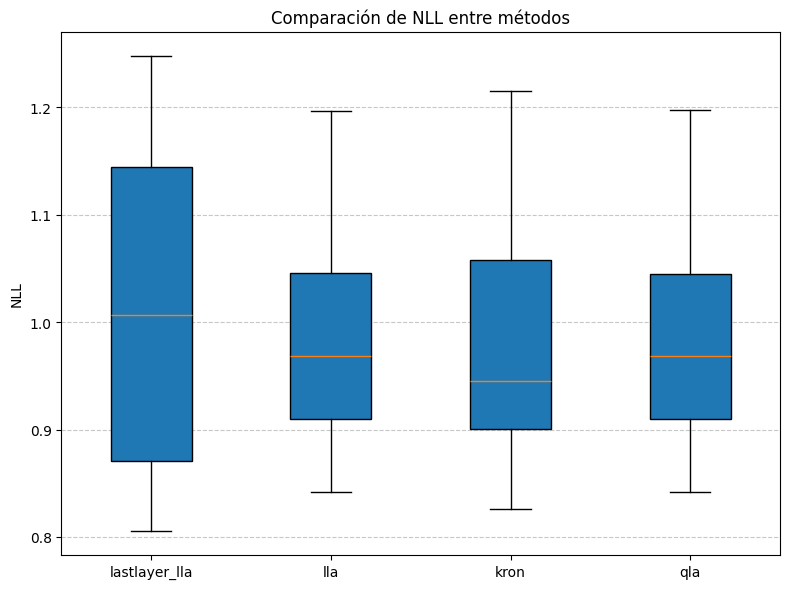

In [12]:
data = []
labels = []

for method, df in method_dfs.items():
    if "NLL" in df.columns:  # Asegurarse de que existe la métrica
        data.append(df["NLL"])
        labels.append(method)

plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True)

plt.ylabel("NLL")
plt.title("Comparación de NLL entre métodos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
for method, df in method_dfs.items():
    if "NLL" in df.columns:
        mean_nll = df["NLL"].mean()
        std_nll = df["NLL"].std()
        print(f"{method}: NLL media = {mean_nll:.4f}, Desviación estándar = {std_nll:.4f}")

lastlayer_lla: NLL media = 1.0011, Desviación estándar = 0.1445
lla: NLL media = 0.9854, Desviación estándar = 0.1037
kron: NLL media = 0.9830, Desviación estándar = 0.1182
qla: NLL media = 0.9856, Desviación estándar = 0.1031
